### Проектный практикум: Регрессия

### Cоветы:

- Укрупнить значения по столбцам: сделать разделение по национаслти на несколько групп
- Перекодировать признаки (категориальные значения)
- Удалить из Target (Enrolled)
- Сделать модель на первом семестре / без оценков за семестры
- При разделении на выборки train / test испоьзовать stratify для категориальных признаков чтобы они были в каждой выборке (сохраяняя баланс классов так как задача на классификацию)
- Использовать логичтическую регреиисю
- Мультиколлениарность - это если корреляция > 0.9. Исключить данное значение
- Для построения модели выбрать признаки, которые максимально точно показывают зависимость (в список для постороения внести те, к которых кореляцию > 0.3)

## 📋 План анализа данных

### 1. **Загрузка данных**
- Прочитать `train.csv`
- Проверить форму, типы данных, пропуски (`df.info()`, `df.head()`)
- Просмотреть описательную статистику (`df.describe()`)

### 2. **Разведочный анализ (EDA)**
- Проанализировать распределение целевой переменной `Target`:
  - Уникальные классы, наличие дисбаланса
- Проверить и удалить дубликаты строк
- Укрупнить категории признаков:
  - Например, сгруппировать `Nationality` в более крупные группы (Local, EU, Non-EU и т.д.)

### 3. **Очистка данных**
- Удалить нерелевантные / проблемные признаки:
  - `id` — идентификатор
  - Признаки с утечкой данных (data leakage):  
    `Curricular units 1st semester (grade/approved/enrolled/...)`,  
    `Curricular units 2nd semester (...)`
  - Макроэкономические показатели: `GDP`, `Inflation rate`, `Unemployment rate` (если не используются)
  - Малоинформативные признаки: `Application order`, `International` (при низкой вариативности)
- Удалить строки с `Target == 'Enrolled'`, если задача — бинарная классификация (Dropout vs Graduate)

### 4. **Визуализация очищенных данных**
- Визуализировать распределения числовых признаков:
  - Гистограммы / плотности: `Admission grade`, `Age at enrollment`, `Previous qualification (grade)` и др.
  - Оценить близость к нормальному распределению
- Построить boxplot / violin plot:
  - `Target` против ключевых признаков (например, возраст, оценки)

### 5. **Подготовка признаков**
- Корректно закодировать категориальные переменные:
  - Номинальные → One-Hot Encoding
  - Порядковые → Label/Ordinal Encoding
- Обработать пропущенные значения (если остались)
- При необходимости — масштабировать числовые признаки

### 6. **Анализ взаимосвязей и отбор признаков**
- Рассчитать корреляционную матрицу:
  - Использовать **Spearman** или **Phi-K** (учитывают категориальные признаки)
  - Построить heatmap
- Выявить мультиколлинеарность:
  - Удалить признаки с корреляцией > 0.9
- Отобрать признаки с умеренной/сильной связью с `Target`:
  - Абсолютная корреляция > 0.3 (или другой порог по обоснованию)

### 7. **Разделение на выборки**
- Разделить данные на `train` и `test`
- Использовать `stratify=Target` для сохранения пропорций классов в обеих выборках

### 8. **Построение модели**
- Обучить **логистическую регрессию** на:
  - Только признаках, доступных **до начала семестра** (без оценок за семестр)
  - Или на полном наборе (для сравнения)
- Оценить качество модели:
  - Accuracy, Precision, Recall, F1, ROC-AUC
  - Матрица ошибок, ROC-кривая

### 9. **Интерпретация и выводы**
- Проанализировать коэффициенты логистической регрессии
- Определить наиболее значимые признаки
- Сформулировать рекомендации и возможные улучшения

### Установка пакетов

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.pipeline import make_pipeline
!pip install phik
import phik
from phik.report import plot_correlation_matrix

### Загрузка данных

In [2]:
import pandas as pd

df = pd.read_csv('./data/train.csv')
df = df.copy()

print("Размерность датасета:", df.shape)

print('\n=== Общая инфомация о датасете ===')
print(df.info())

print('\n=== Основная статичтисекая инфомация ===')
print(df.describe())

print('\n=== Пример данных из датасета ===')
df.head()

Размерность датасета: (76518, 38)

=== Общая инфомация о датасете ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                   

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


### Fast анализ (EDA)

In [3]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Оценка успеваемости")
# profile.to_file('./profile_report.html')
# profile

### Разведочный анализ (EDA)


Распределение целевой переменной Target

=== Уникальные значения Target ===
Target
Graduate    36282
Dropout     25296
Enrolled    14940
Name: count, dtype: int64

=== Распеделение Target в % ===
Target
Graduate    47.416294
Dropout     33.058888
Enrolled    19.524818
Name: proportion, dtype: float64

=== График распределения целевой переменной ===

Кол-во дубликатов: 0


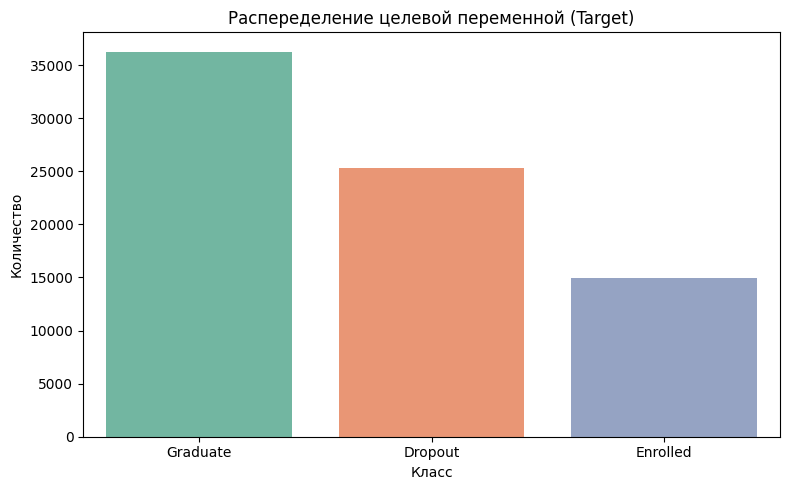

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

# Вывод характеристик
print("=== Уникальные значения Target ===")
print(df["Target"].value_counts())

print("\n=== Распеделение Target в % ===")
# print(df['Target'].unique())
print(df['Target'].value_counts(normalize=True) * 100)
# print(df.isna().sum())

print("\n=== График распределения целевой переменной ===")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Target', hue='Target', palette='Set2', legend=False)
# sns.countplot(data=df, x="Target", palette="Set2")
plt.title('Распеределение целевой переменной (Target)')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.tight_layout()
plt.savefig('./img/target_distribution.png') 
# plt.show()

duplicates = df.duplicated().sum()
print(f"\nКол-во дубликатов: {duplicates}")


Укрупнение категории

In [5]:
unique_nationality = df['Nacionality'].value_counts()
print(f"\nУникальные национальности: \n{unique_nationality}")

df['Nacionality_binary'] = df['Nacionality'].apply(lambda x: 0 if x == 1 else 1)
print(f"\nКодирует национальность в бинарное поле: \n{df['Nacionality_binary']}")


Уникальные национальности: 
Nacionality
1      76013
41       221
26        67
6         56
22        56
24        15
11        15
2         13
103       12
105        9
101        9
100        9
21         6
25         6
62         6
17         2
109        2
32         1
Name: count, dtype: int64

Кодирует национальность в бинарное поле: 
0        0
1        0
2        0
3        0
4        0
        ..
76513    0
76514    0
76515    0
76516    0
76517    0
Name: Nacionality_binary, Length: 76518, dtype: int64


### Очистка данных

**📊 Описание признаков (для классификации)**

**Цель**: предсказать `Target` = `Dropout` / `Enrolled` / `Graduate`

**Оставить (13 ключевых признаков)**
- `Marital status` — семейное положение  
- `Application mode` — способ подачи заявки  
- `Course` — выбранная программа (категория!)  
- `Daytime/evening attendance` — дневной/вечерний формат  
- `Previous qualification` — предыдущий уровень образования  
- `Admission grade` — вступительный балл  
- `Mother's qualification` / `Father's qualification` — образование родителей  
- `Mother's occupation` / `Father's occupation` — профессии родителей  
- `Gender` — пол  
- `Scholarship holder` — стипендиат  
- `Age at enrollment` — возраст при поступлении  

**🚫 Удалить (утечка / шум / не относится)**
- ❌ Все `Curricular units ...` — **утечка данных!** (содержат будущее)  
- ❌ `id`, `Application order`, `Nacionality`, `Displaced`, `Educational special needs`, `Tuition fees up to date`, `International` — мало информации  
- ❌ `Unemployment rate`, `Inflation rate`, `GDP` — макроэкономика, не про студента  
- ⚠️ `Previous qualification (grade)` — сильно коррелирует с `Admission grade` → оставить только один  


In [6]:
print(df.columns)
print(f"Старая размерность: {df.shape}")

# Удаление результатов второго семестра (устранить data leakege)
curricular_cols = [
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
]

# Макроэкономические признаки
macro_cols = [
    'GDP', 
    'Inflation rate', 
    'Unemployment rate'
]

# Дублирующиеся параметры
duplicate_colls = [
    'International', # Nacionality
    'Previous qualification (grade)' # Admission grade
]

# 'Tuition fees up to date'

# Малозначительные показатели
insignificant_coll = [
    'Application order'
    'Educational special needs',
    'Application mode' # неуверен что надо удалять
]

coll_to_drop = ['id'] + curricular_cols + macro_cols + duplicate_colls + insignificant_coll

df = df.drop(columns=coll_to_drop, errors='ignore')

# Удаляем строки, где Target == 'Enrolled'
df = df[df['Target'] != 'Enrolled'].reset_index(drop=True)
print(f"\nНовая размерность: {df.shape}")

# Посмотрим, как выглядит датафрейм после очистки
print("\nИнформация о датафрейме после очистки:")
df.info()

Index(['id', 'Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units

### Визуализация очищенных данных

Распределения числовых признаков (histplot)

In [ ]:
# Гистограммы + плотности
from matplotlib import pyplot as plt
import seaborn as sns

# len(df.columns)
numeric_cols = df.select_dtypes('number')

fig, axes = plt.subplots(1, len(numeric_cols), figsize=(16, 4))

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Распределение: {col}')

plt.tight_layout()
plt.show()

# numeric_cols

KeyboardInterrupt: 

Распределения числовых признаков (boxplot)

In [ ]:
# fig, axes = plt.subplots(1, len(numeric_cols), figsize=(18, 5))

# for i, col in enumerate(numeric_cols):
#     sns.boxplot(data=df, x='Target', y=col, ax=axes[i], palette='Set2')
#     axes[i].set_title(f'{col} по Target')

# plt.tight_layout()
# plt.show()

### Таблица корреляции

In [ ]:
# import phik
# from phik.report import plot_correlation_matrix

# corr_matrix = df.phik_matrix()

interval columns not set, guessing: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)']


График соотношения: Оценка при входе * Успешность окончания